In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Find Dependency

In [2]:
find_deps_df = pd.read_csv('../tasks_output/find_deps.csv')
find_deps_df.columns

Index(['Benchmark Id', 'Benchmark Name', 'Benchmark Family', 'LTL Formula',
       'Input Variables', 'Output Variables', 'Total Input Variables',
       'Total Output Variables', 'Status', 'Error Message', 'Total Duration',
       'Dependent Variables', 'Total Dependent Variables',
       'Independent Variables', 'Total Independent Variables',
       'Dependency Ratio', 'Is Automaton Built', 'Automaton Build Duration',
       'Automaton Total States', 'Automaton Total Edges', 'Total Pair States',
       'Find Pair States Duration', 'Find Dependency Duration'],
      dtype='object')

In [3]:
total_deps_df = find_deps_df[find_deps_df["Total Dependent Variables"] > 0][["Benchmark Name", "Benchmark Family", "Total Dependent Variables"]]
total_deps_df

,Benchmark Name,Benchmark Family,Total Dependent Variables
4,Window2_54e1f7d2,tsl_smart_home_jarvis/extracted-benchmarks,3.0
11,LightsTotal_2c5b09da,tsl_smart_home_jarvis/extracted-benchmarks,2.0
12,OneCounterGuiA4,tsl_paper,3.0
14,Window2_aeb1d897,tsl_smart_home_jarvis/extracted-benchmarks,2.0
16,CheckCoffeMachine_f3987563,tsl_smart_home_jarvis/extracted-benchmarks,1.0
...,...,...,...
1128,EscalatorCounting,tsl_paper,5.0
1130,TwoCountersDisButA3,tsl_paper,4.0
1135,Shades2_42dc4fff,tsl_smart_home_jarvis/extracted-benchmarks,1.0
1137,FelixSpecFixed2_fa4d4ce3,tsl_smart_home_jarvis/extracted-benchmarks,10.0


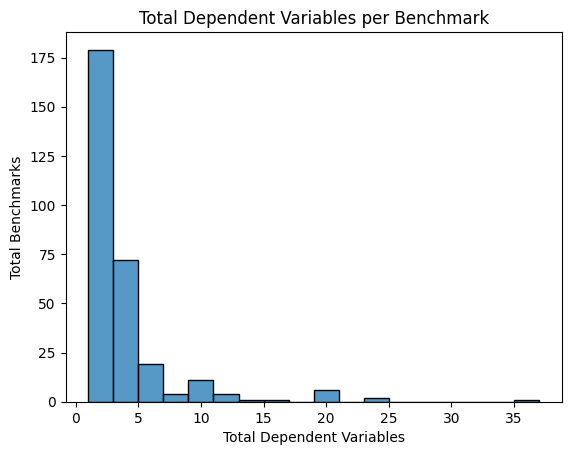

In [4]:
ax = sns.histplot(data=total_deps_df, x="Total Dependent Variables", binwidth=2)
ax.set_ylabel("Total Benchmarks")
ax.set_title("Total Dependent Variables per Benchmark");

# DepSynt Tool

In [5]:
depsynt_df = pd.read_csv('../tasks_output/depsynt.csv')
headers = {
    "AUTOMATON_BUILD": "Automaton Build Duration",
    "FIND_DEPS_DURATION": "Find Dependency Duration",
    "INDEPENDENTS_SYNTHESIS": "Independent Synthesis Duration",
    "DEPENDENTS_SYNTHESIS": "Dependent Synthesis Duration",
}
headers_list = list(headers.values())
depsynt_df.columns

Index(['Benchmark Id', 'Benchmark Name', 'Benchmark Family', 'LTL Formula',
       'Input Variables', 'Output Variables', 'Total Input Variables',
       'Total Output Variables', 'Status', 'Error Message', 'Total Duration',
       'Dependent Variables', 'Total Dependent Variables',
       'Independent Variables', 'Total Independent Variables',
       'Dependency Ratio', 'Is Automaton Built', 'Automaton Build Duration',
       'Automaton Total States', 'Automaton Total Edges', 'Total Pair States',
       'Find Pair States Duration', 'Find Dependency Duration',
       'Realizability', 'Independent Synthesis Duration',
       'Dependent Synthesis Duration', 'Merge Strategies Duration',
       'Synthesis Duration'],
      dtype='object')

In [6]:
X = depsynt_df[depsynt_df["Status"] == 'Success']
X = X[headers_list + ["Total Duration"]].copy()
X["Gap Total Duration and Rest"] = depsynt_df["Total Duration"] - depsynt_df[headers_list].sum(axis=1)

X.sort_values(by="Gap Total Duration and Rest", ascending=False, inplace=True)
X

,Automaton Build Duration,Find Dependency Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Total Duration,Gap Total Duration and Rest
331,1690902.0,12000.0,1417631.0,0.0,3120657.0,124.0
129,497.0,13135.0,1771.0,118.0,15531.0,10.0
245,599.0,14964.0,5251335.0,143.0,5267051.0,10.0
143,371.0,13925.0,539.0,149.0,14993.0,9.0
38,238.0,6736.0,5079484.0,78.0,5086544.0,8.0
...,...,...,...,...,...,...
94,3.0,0.0,1.0,0.0,4.0,0.0
128,1.0,0.0,1.0,0.0,2.0,0.0
220,1.0,0.0,1.0,0.0,2.0,0.0
148,1.0,0.0,1.0,0.0,2.0,0.0


In [7]:
def gen_stackplot(should_include_row, plt_title, sort_by = None):
    filtered_depsynt_df = depsynt_df[depsynt_df.apply(should_include_row, axis=1)].copy()
    filtered_depsynt_df[headers_list + ["Synthesis Duration"]] = filtered_depsynt_df[headers_list + ["Synthesis Duration"]].clip(lower=0)
    time_distribution_df = filtered_depsynt_df.copy()
    # Selecting Headers
    time_distribution_df = time_distribution_df[headers_list]
    # Refine Total Duration
    time_distribution_df["Total Duration"] = time_distribution_df[headers_list].sum(axis=1)

    # Sorting by Total Duration
    if sort_by != None:
        time_distribution_df.sort_values(by=sort_by, ascending=True, inplace=True)

    # For now, ignore the case where Total Duration is 0
    time_distribution_df = time_distribution_df[time_distribution_df["Total Duration"] > 0]
    time_distribution_df[headers['AUTOMATON_BUILD']] /= time_distribution_df["Total Duration"]
    time_distribution_df[headers['FIND_DEPS_DURATION']] /= time_distribution_df["Total Duration"]
    time_distribution_df[headers['INDEPENDENTS_SYNTHESIS']] /= time_distribution_df["Total Duration"]
    time_distribution_df[headers['DEPENDENTS_SYNTHESIS']] /= time_distribution_df["Total Duration"]

    plt.figure(figsize=(15,6))
    x = range(0, len(time_distribution_df))
    plt.stackplot(x,
                time_distribution_df[headers['AUTOMATON_BUILD']],
                time_distribution_df[headers['FIND_DEPS_DURATION']],
                time_distribution_df[headers['INDEPENDENTS_SYNTHESIS']],
                time_distribution_df[headers['DEPENDENTS_SYNTHESIS']],
                labels=['Build Automaton','Find Deps','Synthesis Independents','Synthesis Dependents']
    )
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel('ID')
    plt.ylabel('Value')
    plt.title(plt_title)
    # plt.xticks(x)  # This will ensure each ID is shown on the x-axis
    plt.tight_layout()
    plt.show()

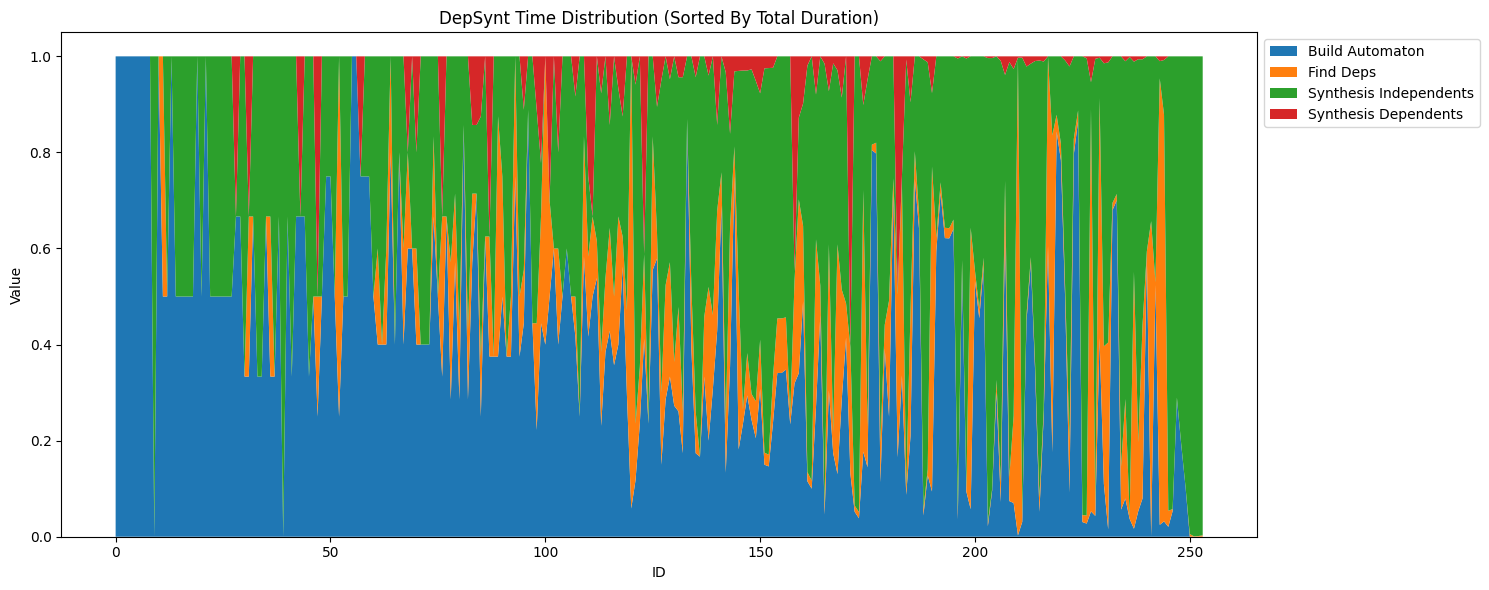

In [10]:
def should_include_row(row):
    status = row["Status"]
    total_deps_var = row["Total Dependent Variables"]
    total_indeps_var = row["Total Independent Variables"]
    
    if status != "Success":
        return False
    if total_deps_var == 0:
        return False
    
    return True

sort_by = "Total Duration"
title = f"DepSynt Time Distribution (Sorted By {sort_by})"
gen_stackplot(should_include_row, title, sort_by="Total Duration")